In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import feature.molecule_dataset as molecule_dataset
import model.graph_adj_x_diffusion as graph_adj_x_diffusion
import model.graph_net as graph_net
import model.util as model_util
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
import rdkit
import IPython
import importlib

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
models_base_path = "/gstore/scratch/u/tsenga5/branched_diffusion/models/trained_models/"

# model_path = os.path.join(models_base_path, "zinc250k_continuous_num_cycles_b0.15/1/last_ckpt.pth")
model_path = os.path.join(models_base_path, "zinc250k_continuous_elements_b0.15/1/last_ckpt.pth")

In [5]:
classes = [0, 1]
branch_defs = [((0, 1), 0.15, 1), ((0,), 0, 0.15), ((1,), 0, 0.15)]

In [6]:
# dataset = molecule_dataset.ZINCDataset(label_method="num_cycles", nums_to_label=[0, 1])
dataset = molecule_dataset.ZINCDataset(label_method="elements")

# Limit classes
inds = np.isin(dataset.target, classes)
dataset.all_smiles = dataset.all_smiles[inds]
dataset.target = dataset.target[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

In [7]:
sde = graph_adj_x_diffusion.AXJointSDE(0.1, 1, 0.2, 1, input_shape)

t_limit = 1

In [8]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/zinc250k_examples/elements"

os.makedirs(out_path, exist_ok=True)

### Import the model

In [9]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [10]:
model = model_util.load_model(
    graph_net.GraphJointNetwork,
    model_path
).to(DEVICE)

### Sample molecules

In [11]:
ATOM_SYMBOLS = ["C", "N", "O", "F", "S", "Cl", "Br", "I", "P"]
BOND_TYPES = [rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE]

def samples_to_adj_x(samps):
    """
    Given a B x M x (M + D) array of adjacency matrices and node features,
    discretizes them and returns the adjacency matrices (B x M x M) and
    node features (B x M x D),
    """
    s = samps.shape[1]
    adj, x = samps[:, :, :s], samps[:, :, s:]
    
    # Discretize
    adj[adj < 0.5] = 0
    adj[(adj >= 0.5) & (adj < 1.5)] = 1
    adj[(adj >= 1.5) & (adj < 2.5)] = 2
    adj[adj >= 2.5] = 3
    adj = np.triu(adj, k=1)
    adj = adj + np.swapaxes(adj, 1, 2)
    x[x < 0.5] = 0
    x[x >= 0.5] = 1
    adj, x = adj.astype(int), x.astype(int)
    return adj, x

def samples_to_rdkmols(adj, x, flags):
    """
    Given a B x M x M adjacency matrix batch and B x M x D node feature
    batch, and a B x M binary array of flags (all NumPy arrays),
    converts them to RDKit molecule objects.
    """
    mol_sizes = np.sum(flags, axis=1)
    atomic_nums = np.argmax(x, axis=2)
    
    mols = []
    for i in range(len(adj)):
        size = mol_sizes[i]
        a, atoms = adj[i][:size][:, :size], atomic_nums[i][:size]
        mol = rdkit.Chem.RWMol()
        
        for atom in atoms:
            mol.AddAtom(rdkit.Chem.Atom(ATOM_SYMBOLS[atom]))
            
        for u, v in zip(*np.nonzero(np.triu(a, k=1))):
            mol.AddBond(int(u), int(v), BOND_TYPES[a[u, v] - 1])
        
        mol.UpdatePropertyCache(strict=False)  # Set valences
        
        mols.append(mol)
    return mols

def plot_molecule(mol):
    mc = rdkit.Chem.Mol(mol.ToBinary())
    rdkit.Chem.Kekulize(mc)
    
    drawer = rdkit.Chem.Draw.rdMolDraw2D.MolDraw2DSVG(450, 150)
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return IPython.display.SVG(svg.replace("svg:",""))

In [12]:
# samples = {}
# num_samples_per_class = 32
# for class_to_sample in classes:
#     # Sample some initial node flags
#     inds = np.random.choice(np.where(dataset.target == class_to_sample)[0], size=num_samples_per_class, replace=True)
#     batch = torch.stack([dataset[i][0] for i in inds], dim=0)
#     adj = batch[:, :, :batch.shape[1]]
#     sampled_flags = graph_net.node_flags(adj)
    
#     sample = graph_adj_x_diffusion.generate_continuous_branched_samples(
#         model, sde, class_to_sample, class_time_to_branch_tensor,
#         sampled_flags, num_samples=num_samples_per_class, t_limit=t_limit,
#         num_steps=1000, verbose=True
#     ).cpu().numpy()
#     samples[class_to_sample] = sample

In [13]:
# # Convert to molecule objects
# mol_samples = {}
# for class_to_sample in classes:
#     samps = samples[class_to_sample]
    
#     # Separate and discretize
#     adj, x = samples_to_adj_x(samps)
    
#     # Convert
#     mol_samples[class_to_sample] = samples_to_rdkmols(adj, x, sampled_flags.cpu().numpy().astype(int))

In [14]:
# for class_to_sample in classes:
#     print(class_to_sample)
#     for mol in mol_samples[class_to_sample]:
#         IPython.display.display(plot_molecule(mol))
#         print(rdkit.Chem.MolToSmiles(mol))

### Transmutation

In [18]:
class_1, class_2 = 0, 1
branch_time = branch_defs[min(
    range(len(branch_defs)),
    key=(lambda i: branch_defs[i][1] if (
        class_1 in branch_defs[i][0] and class_2 in branch_defs[i][0]
    ) else float("inf"))
)][1]

orig_1 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.target == class_1)[0], size=200, replace=False)
])
orig_2 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.target == class_2)[0], size=200, replace=False)
])
orig_1_adj = orig_1[:, :, :orig_1.shape[1]]
orig_1_flags = graph_net.node_flags(orig_1_adj)
orig_2_adj = orig_2[:, :, :orig_2.shape[1]]
orig_2_flags = graph_net.node_flags(orig_2_adj)

time_steps = 10
all_t = np.linspace(0, branch_time, time_steps)
forward_1_to_2 = np.empty((len(all_t),) + orig_1.shape)
backward_1_to_2 = np.empty((len(all_t) - 1,) + orig_1.shape)
forward_2_to_1 = np.empty((len(all_t),) + orig_2.shape)
backward_2_to_1 = np.empty((len(all_t) - 1,) + orig_2.shape)
for t_i, t in enumerate(all_t):
    if t_i == 0:
        forward_1_to_2[t_i], forward_2_to_1[t_i] = orig_1.cpu().numpy(), orig_2.cpu().numpy()
    else:
        forward_1_to_2[t_i] = sde.forward(
            orig_1, torch.ones(len(orig_1)).to(DEVICE) * t
        )[0].cpu().numpy()
        forward_2_to_1[t_i] = sde.forward(
            orig_2, torch.ones(len(orig_2)).to(DEVICE) * t
        )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_1_to_2 = torch.tensor(forward_1_to_2[-1]).to(DEVICE).float()
last_2_to_1 = torch.tensor(forward_2_to_1[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_1_to_2 = graph_adj_x_diffusion.generate_continuous_branched_samples(
        model, sde, class_2, class_time_to_branch_tensor,
        orig_1_flags, t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_1.shape[0], initial_samples=last_1_to_2,
        num_steps=50
    )
    backward_1_to_2[t_i] = last_1_to_2.cpu().numpy()

    last_2_to_1 = graph_adj_x_diffusion.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor,
        orig_2_flags, t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_2.shape[0], initial_samples=last_2_to_1,
        num_steps=50
    )
    backward_2_to_1[t_i] = last_2_to_1.cpu().numpy()

orig_1, orig_2 = orig_1.cpu().numpy(), orig_2.cpu().numpy()
before_1_to_2, after_1_to_2 = forward_1_to_2[0], backward_1_to_2[-1]
before_2_to_1, after_2_to_1 = forward_2_to_1[0], backward_2_to_1[-1]

In [19]:
# Convert to molecule objects
before_1_to_2_adj, before_1_to_2_x = samples_to_adj_x(before_1_to_2)
before_1_to_2_mols = samples_to_rdkmols(before_1_to_2_adj, before_1_to_2_x, orig_1_flags.cpu().numpy().astype(int))
after_1_to_2_adj, after_1_to_2_x = samples_to_adj_x(after_1_to_2)
after_1_to_2_mols = samples_to_rdkmols(after_1_to_2_adj, after_1_to_2_x, orig_1_flags.cpu().numpy().astype(int))
before_2_to_1_adj, before_2_to_1_x = samples_to_adj_x(before_2_to_1)
before_2_to_1_mols = samples_to_rdkmols(before_2_to_1_adj, before_2_to_1_x, orig_2_flags.cpu().numpy().astype(int))
after_2_to_1_adj, after_2_to_1_x = samples_to_adj_x(after_2_to_1)
after_2_to_1_mols = samples_to_rdkmols(after_2_to_1_adj, after_2_to_1_x, orig_2_flags.cpu().numpy().astype(int))

0 to 1
0


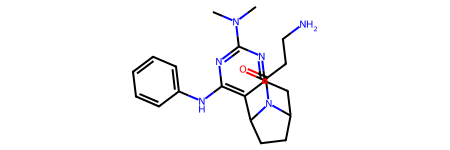

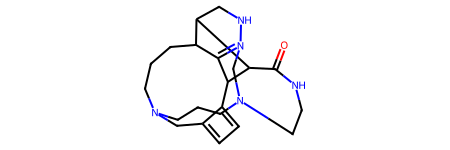

1


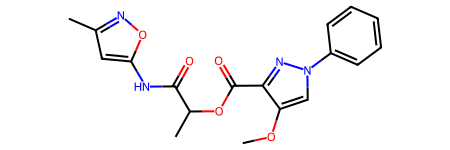

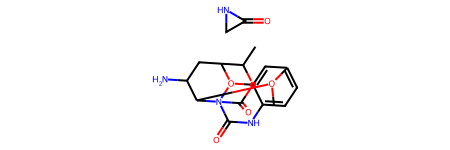

2


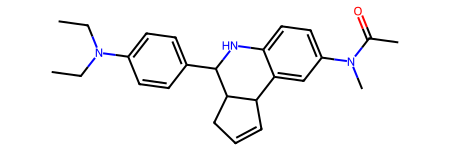

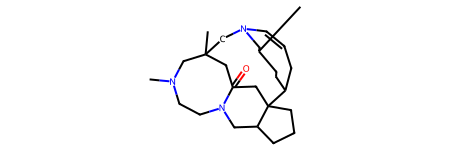

3


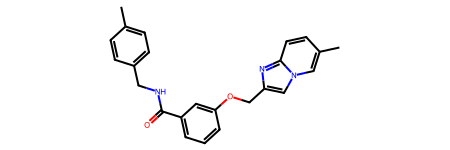

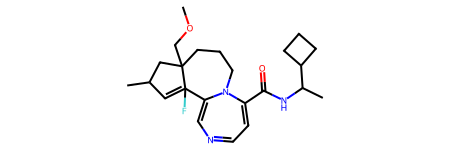

4


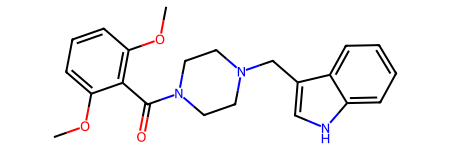

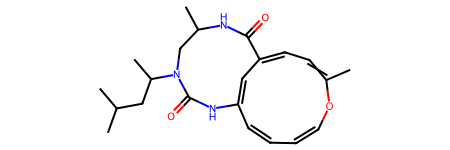

5


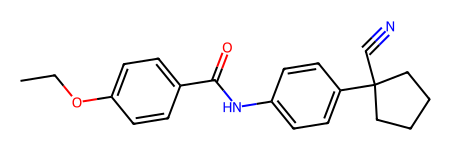

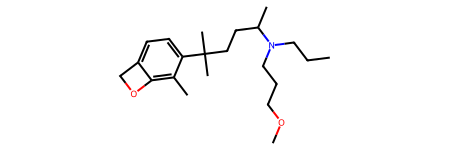

6


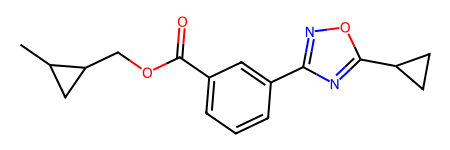

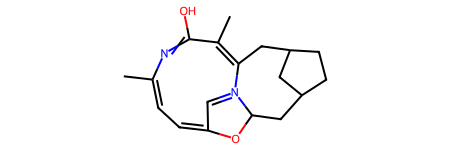

7


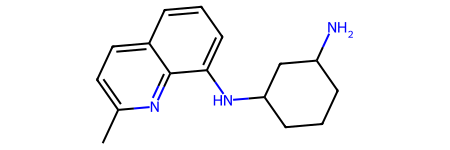

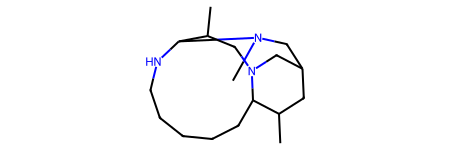

8


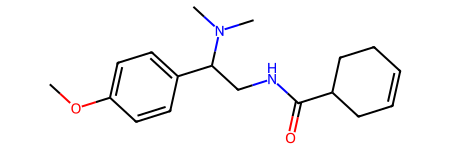

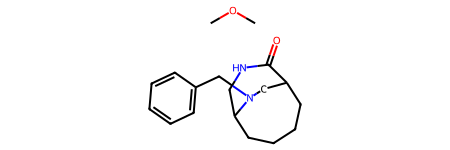

9


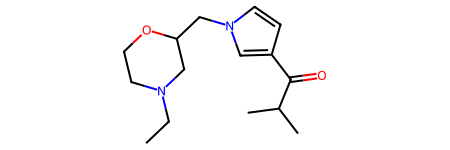

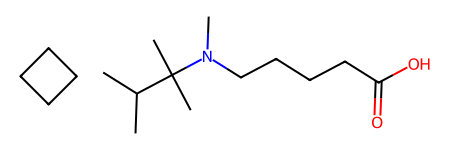

10


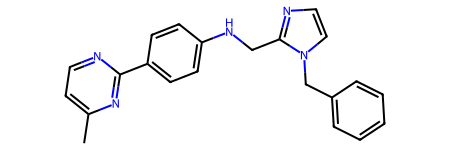

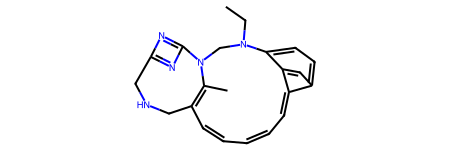

11


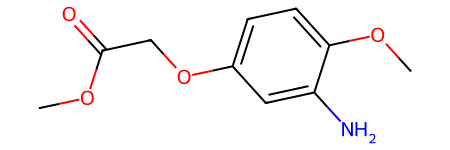

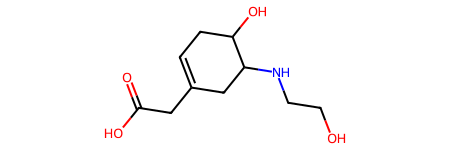

12


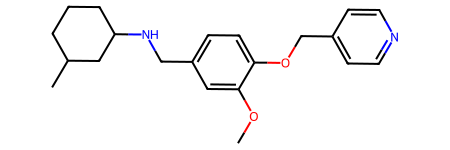

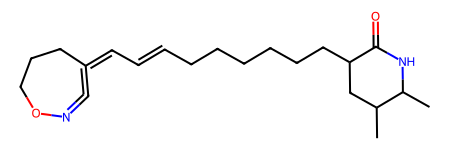

13


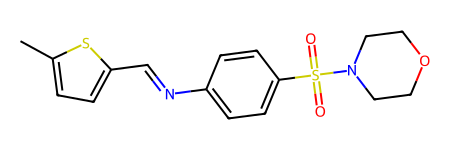

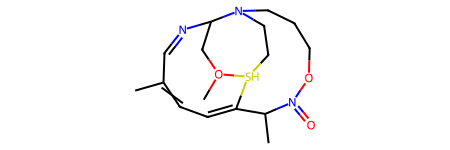

14


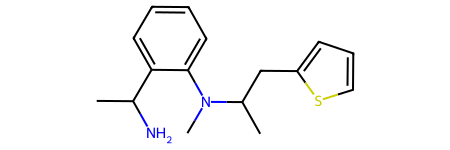

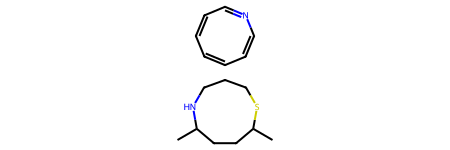

15


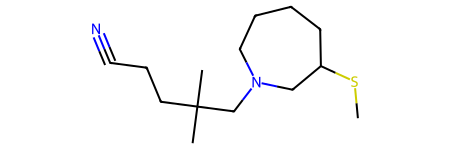

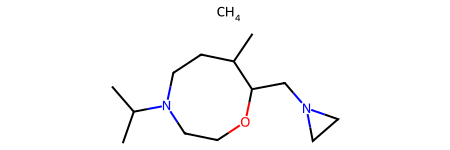

16


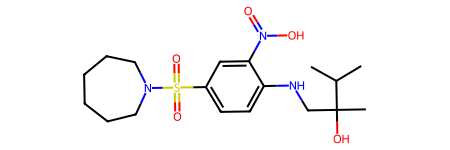

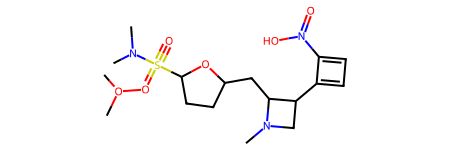

17


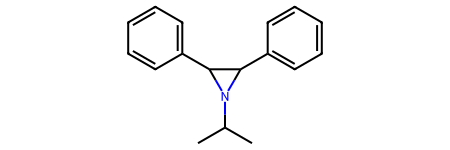

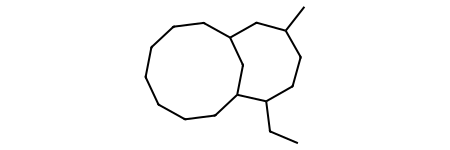

18


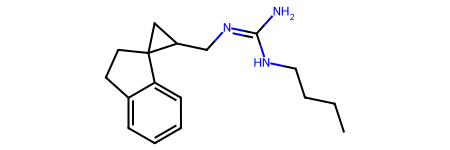

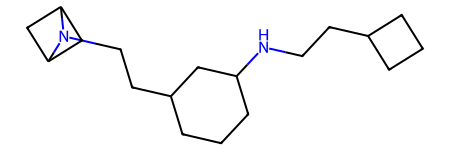

19


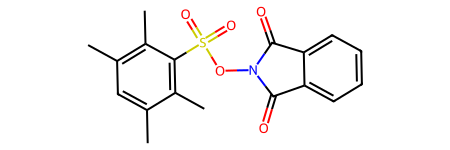

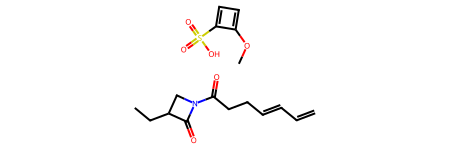

20


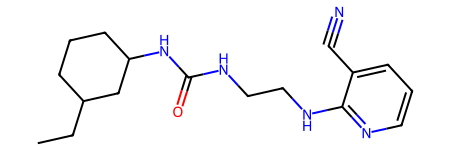

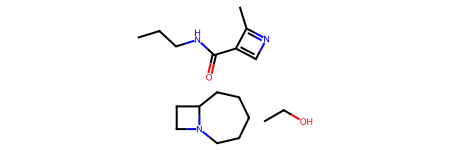

21


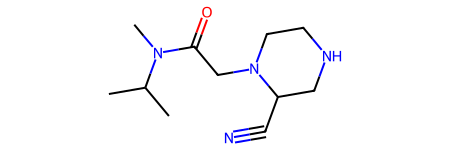

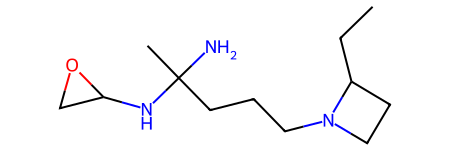

22


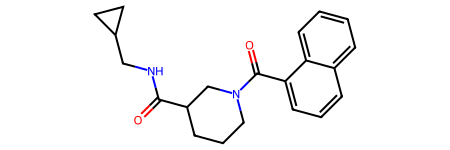

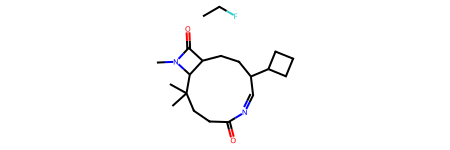

23


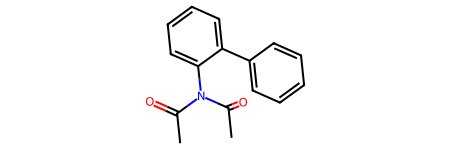

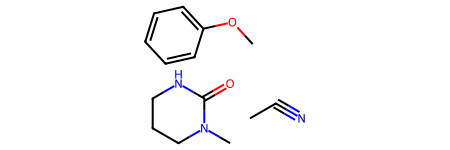

24


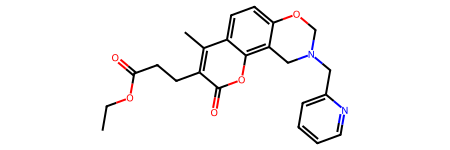

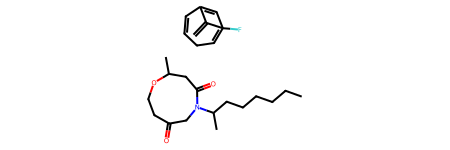

25


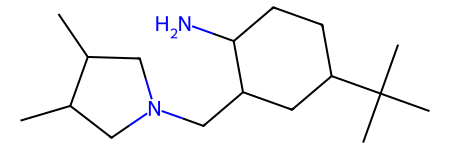

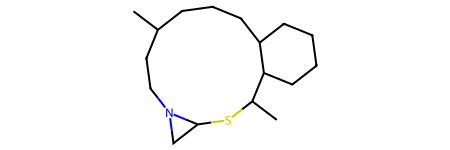

26


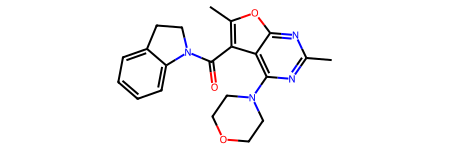

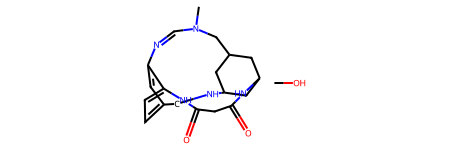

27


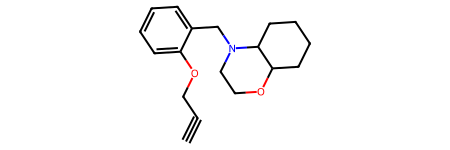

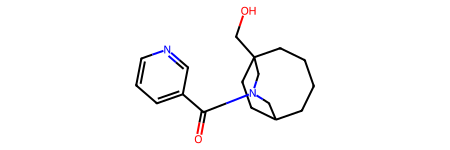

28


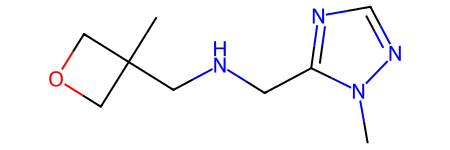

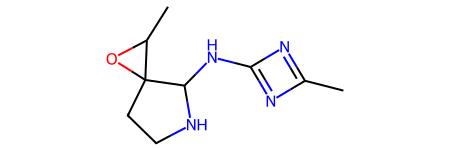

29


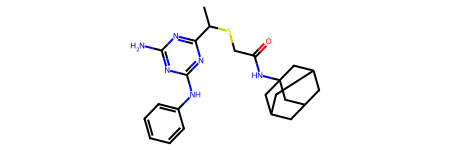

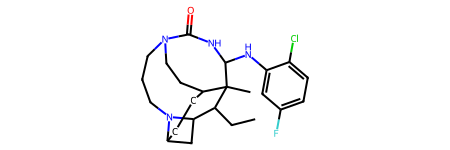

30


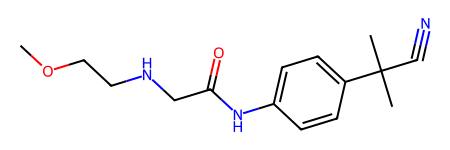

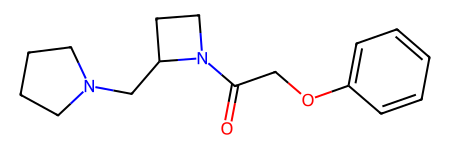

31


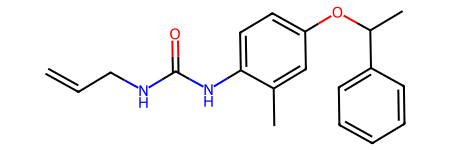

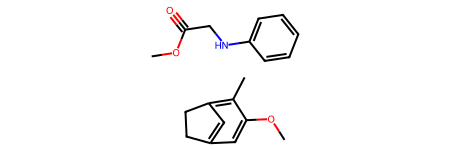

1 to 0
0


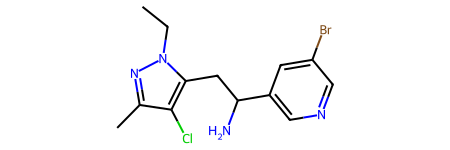

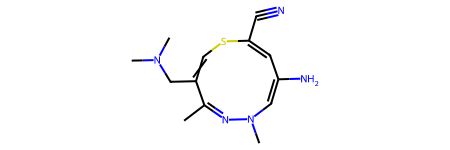

1


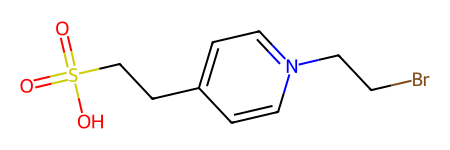

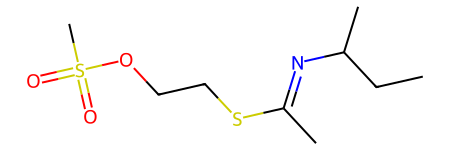

2


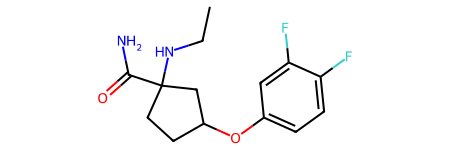

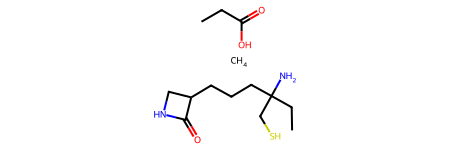

3


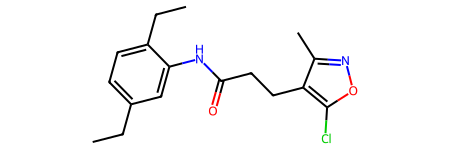

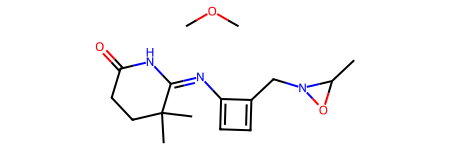

4


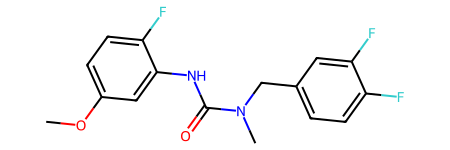

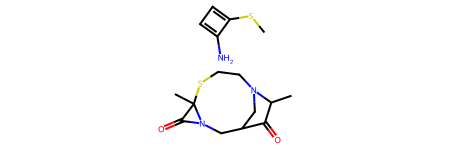

5


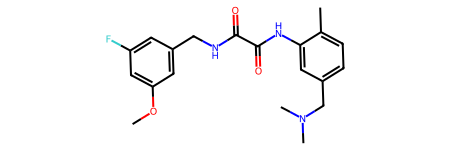

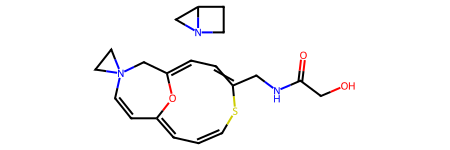

6


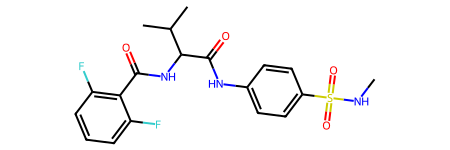

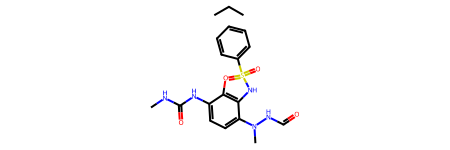

7


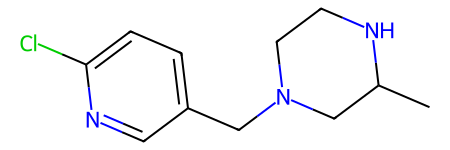

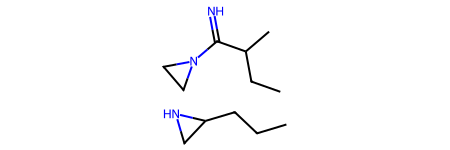

8


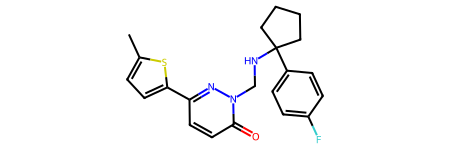

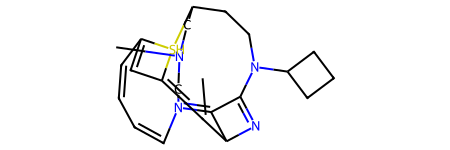

9


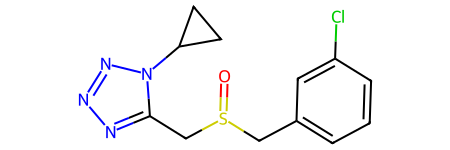

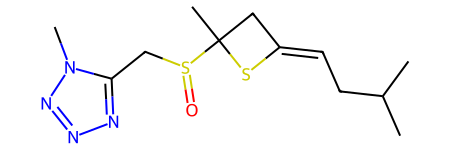

10


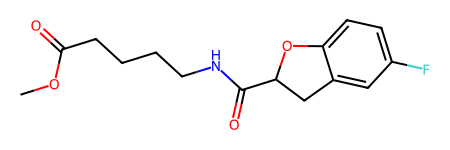

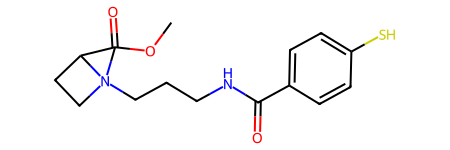

11


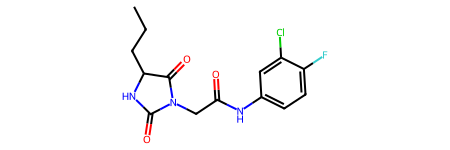

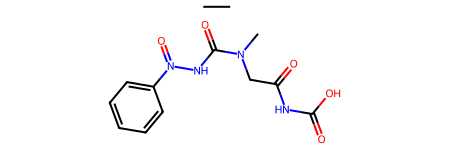

12


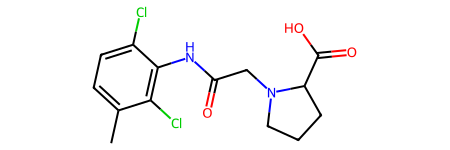

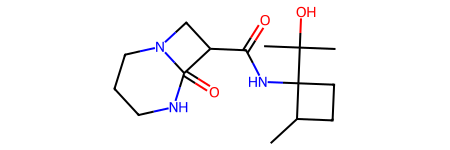

13


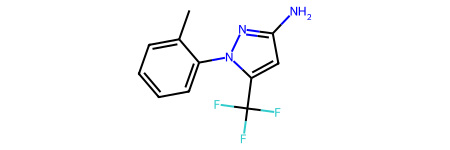

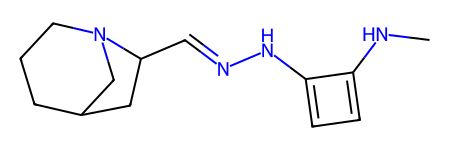

14


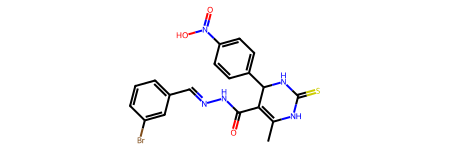

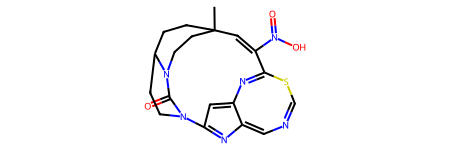

15


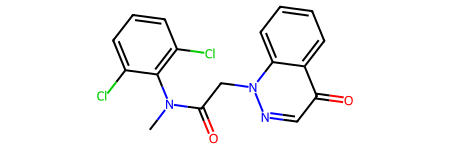

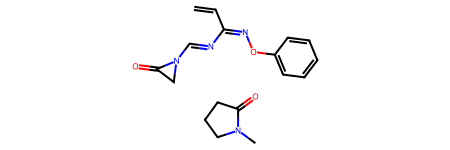

16


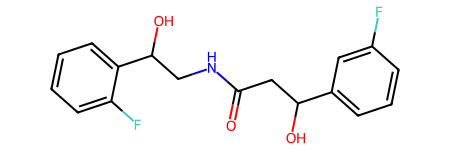

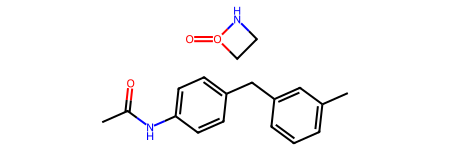

17


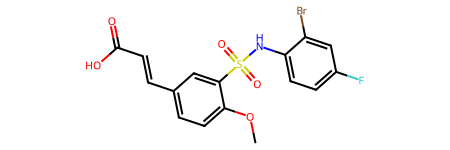

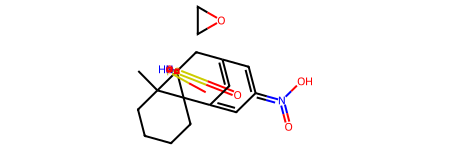

18


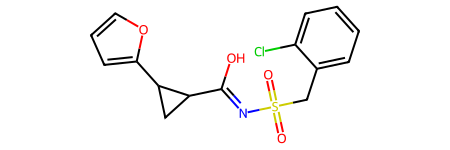

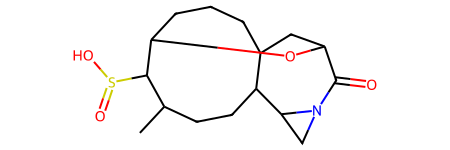

19


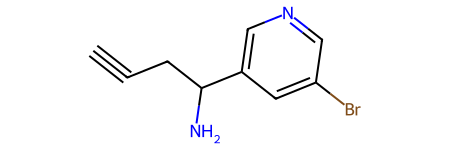

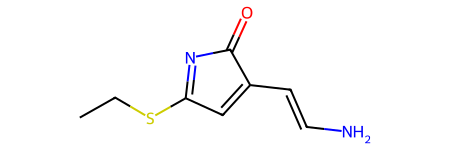

20


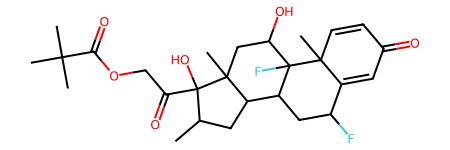

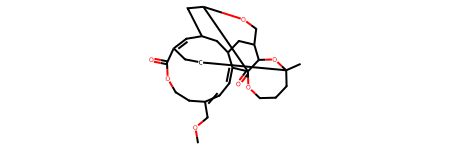

21


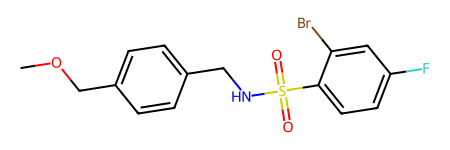

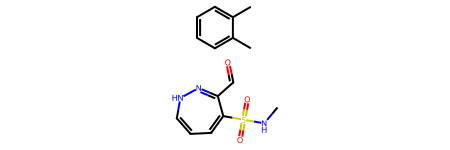

22


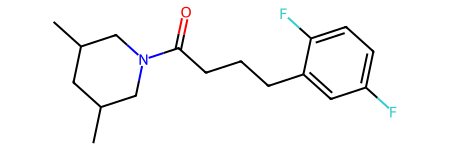

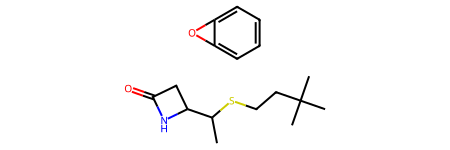

23


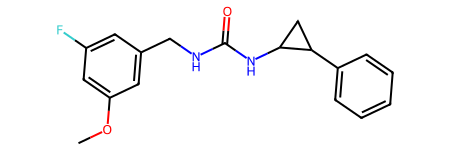

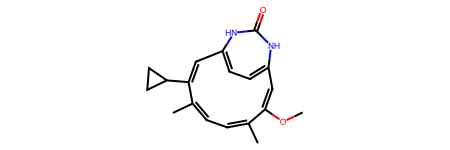

24


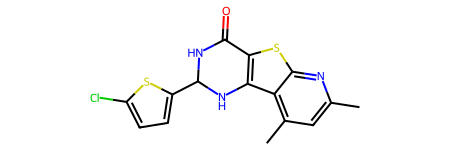

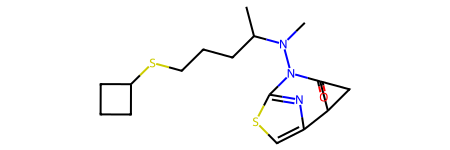

25


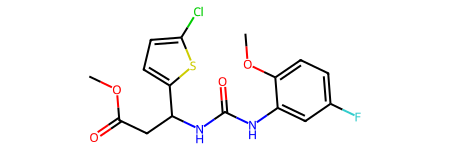

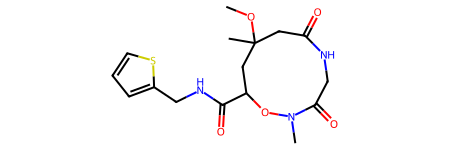

26


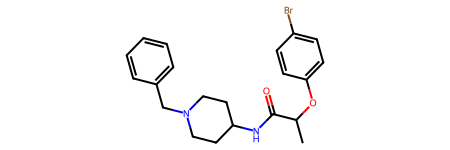

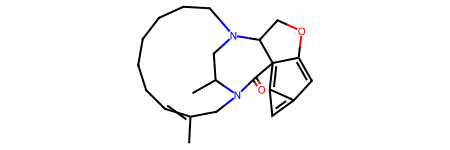

27


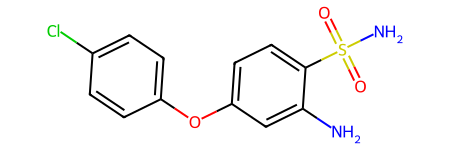

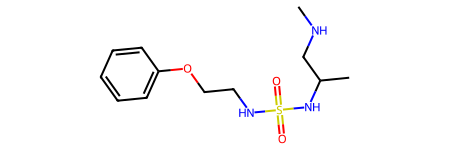

28


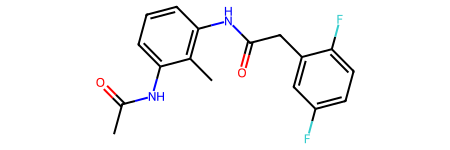

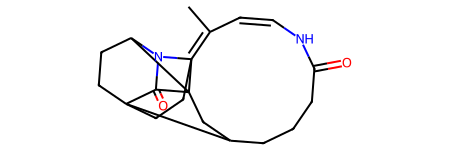

29


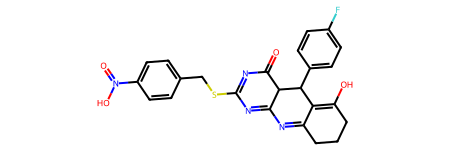

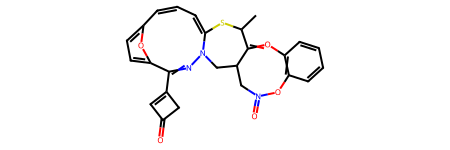

30


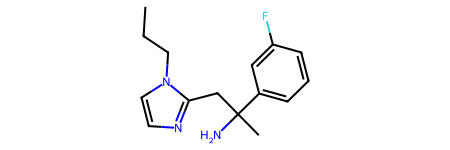

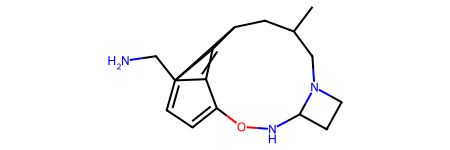

31


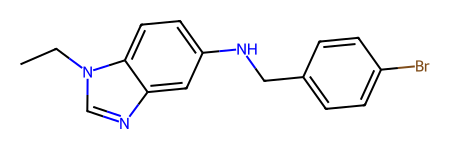

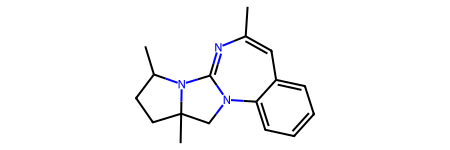

In [20]:
print("%s to %s" % (class_1, class_2))
for i in range(min(32, len(before_1_to_2_mols))):
    print(i)
    mol = plot_molecule(before_1_to_2_mols[i])
    IPython.display.display(mol)
    with open(os.path.join(out_path, "trans_%s_to_%s_ex%d_before.svg" % (class_1, class_2, i)), "w") as f:
        f.write(mol.data)
    mol = plot_molecule(after_1_to_2_mols[i])
    IPython.display.display(mol)
    with open(os.path.join(out_path, "trans_%s_to_%s_ex%d_after.svg" % (class_1, class_2, i)), "w") as f:
        f.write(mol.data)
    
print("%s to %s" % (class_2, class_1))
for i in range(min(32, len(before_2_to_1_mols))):
    print(i)
    mol = plot_molecule(before_2_to_1_mols[i])
    IPython.display.display(mol)
    with open(os.path.join(out_path, "trans_%s_to_%s_ex%d_before.svg" % (class_2, class_1, i)), "w") as f:
        f.write(mol.data)
    mol = plot_molecule(after_2_to_1_mols[i])
    IPython.display.display(mol)
    with open(os.path.join(out_path, "trans_%s_to_%s_ex%d_after.svg" % (class_2, class_1, i)), "w") as f:
        f.write(mol.data)